# Notebook for Linear Models (LR, EN, RF)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../scripts")
import utils

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [7]:
SEED = 42
REMOVE_COLS = []
OVERWRITE = False

DATA_DIR = '../data/processed/SRD_Lysekil.pkl'
PROJ_NAME = 'linear_models_case_2/'
FIGS_DIR = '/Users/junxingli/Desktop/master_thesis/figs/lm/' + PROJ_NAME

class LinearModel:
    def __init__(self, dir_data=DATA_DIR, display=True):
        self.dir_data = dir_data
        self.display = display
        self.data = pd.read_pickle(dir_data)
        pass
    
    def preprocess(self, state=None, test_size=0.20, random_state=SEED):
        """
        Set state to 'steady-state' to remove transient data (Case 1) or leave
        empty to include all data (Case 2).
        """
        self.state = state
        self.test_size = test_size
        
        if state == 'steady-state':
            self.data = self.data[self.data['Status'] == 'Stable']
            
        self.data = self.data.drop(['Status'], axis=1)
        self.X = self.data.drop(['SRD'] + REMOVE_COLS, axis=1)
        self.y = self.data[['Time', 'SRD']]
        X_train, X_test, y_train, y_test = train_test_split(self.X, 
                                                            self.y, 
                                                            test_size=self.test_size, 
                                                            random_state=random_state,
                                                            shuffle=True)
        
        self.time_train, self.time_test = X_train['Time'], X_test['Time']
        self.X_train, self.X_test = X_train.drop('Time', axis=1), X_test.drop('Time', axis=1)
        self.y_train, self.y_test = y_train.drop('Time', axis=1), y_test.drop('Time', axis=1)
        
        cols = self.X_train.columns
        self.scaler = StandardScaler()
        
        self.X_train[cols] = self.scaler.fit_transform(self.X_train[cols])
        self.X_test[cols] = self.scaler.transform(self.X_test[cols])
        
        self.y_train['SRD'] = self.scaler.fit_transform(self.y_train['SRD'].values.reshape(-1, 1))
        self.y_test['SRD'] = self.scaler.transform(self.y_test['SRD'].values.reshape(-1, 1))
        pass
    
    def fit_linear_regression_sfs(self, cv_folds=5, scoring='neg_root_mean_squared_error', num_feat='best'):
        """
        Perform Sequential Feature Selection (SFS) with Linear Regression.
        """
        ols1 = LinearRegression()
        ols2 = LinearRegression()
        sfs = SFS(ols1, 
                  k_features=num_feat, 
                  forward=False, 
                  scoring=scoring, 
                  cv=cv_folds, 
                  n_jobs=-1)

        pipe = Pipeline([('sfs', sfs), 
                         ('ols2', ols2)])

        bs = BayesSearchCV(pipe,
                          {
                              'sfs__floating': [True, False],
                          }, 
                          n_iter=1,
                          cv=cv_folds, 
                          scoring=scoring,
                          random_state=SEED)
        
        bs = bs.fit(self.X_train, self.y_train)
        print("---------------------------------------------------")
        print("LINEAR REGRESSION WITH SEQUENTIAL FEATURE SELECTION")
        print("---------------------------------------------------")
        df_train, rmse_train, r2_train = utils.generate_prediction_df(bs, self.scaler, self.X_train, self.y_train, self.time_train)
        df_test, rmse_test, r2_test = utils.generate_prediction_df(bs, self.scaler, self.X_test, self.y_test, self.time_test)
        self.SFS_results(bs)
        self.plot_coefficients(bs, 'ols2', 'LR-COEFF.pdf')
        
        return df_train, df_test
    
    def fit_elastic_net_regression(self, cv_folds=5, scoring='neg_root_mean_squared_error'):
        """
        Perform Elastic Net Regression.
        """
        self.cv_folds = cv_folds
        self.scoring = scoring
        
        en = ElasticNet(max_iter=10000, random_state=SEED)
        pipe = Pipeline([('elastic_net', en)])
        
        bs = BayesSearchCV(pipe,
                          {
                              'elastic_net__alpha': Real(0.01, 10, prior='log-uniform'),
                              'elastic_net__l1_ratio': Real(0.01, 1, prior='log-uniform'),
                          }, 
                          n_iter=50,
                          cv=self.cv_folds, 
                          scoring='neg_root_mean_squared_error',
                          random_state=SEED)
        
        bs = bs.fit(self.X_train, self.y_train)
        print("---------------------------------------------------")
        print("ELASTIC NET REGRESSION")
        print("---------------------------------------------------")
        df_train, rmse_train, r2_train = utils.generate_prediction_df(bs, self.scaler, self.X_train, self.y_train, self.time_train)
        df_test, rmse_test, r2_test = utils.generate_prediction_df(bs, self.scaler, self.X_test, self.y_test, self.time_test)
        self.BS_results(bs)
        self.plot_coefficients(bs, 'elastic_net', 'EN-COEFF.pdf')
        
        return df_train, df_test
              
    def fit_random_forest_regression(self, cv_folds=5, scoring='neg_root_mean_squared_error'):
        """
        Perform Random Forest Regression.
        """
        self.cv_folds = cv_folds
        self.scoring = scoring
        
        rf = RandomForestRegressor(random_state=SEED)
        pipe = Pipeline([('random_forest', rf)])
        
        bs = BayesSearchCV(pipe,
                        {
                            'random_forest__n_estimators': Integer(10, 500),
                            'random_forest__max_depth': Integer(2, 20),
                            'random_forest__min_samples_split': Integer(2, 10),
                            'random_forest__min_samples_leaf': Integer(1, 10),
                            'random_forest__max_features': Real(0.1, 1.0),
                        }, 
                        n_iter=2,
                        n_jobs=-1,
                        cv=self.cv_folds, 
                        scoring='neg_root_mean_squared_error',
                        random_state=SEED)
        
        bs = bs.fit(self.X_train, self.y_train)
        print("---------------------------------------------------")
        print("RANDOM FOREST REGRESSION")
        print("---------------------------------------------------")
        df_train, rmse_train, r2_train = utils.generate_prediction_df(bs, self.scaler, self.X_train, self.y_train, self.time_train)
        df_test, rmse_test, r2_test = utils.generate_prediction_df(bs, self.scaler, self.X_test, self.y_test, self.time_test) 
        self.RF_results(bs)
        
        return df_train, df_test
              
    def SFS_results(self, bs):
        """
        Print the results of the Sequential Feature Selection (SFS) with Linear Regression.
        """
        best_variables = bs.best_estimator_.named_steps['sfs'].k_feature_names_
        total_variables = len(self.X_train.columns)
        
        # RMSe is the negative of the score for each SFS iteration
        avg_scores = []
        for subset_size, subset_info in bs.best_estimator_.named_steps['sfs'].subsets_.items():
            avg_scores.append(np.sqrt(-subset_info["avg_score"]))
            
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(1, len(avg_scores)+1)], avg_scores, marker='o')
        plt.xlabel('Number of variables')
        plt.ylabel('Validation RMSE')
        plt.xticks([i for i in range(1, len(avg_scores)+1)])
        utils.save_file(plt.gcf(), FIGS_DIR, 'LR-SFS.pdf', 'matplotlib', overwrite=OVERWRITE)
        
        if self.display == True:
            print("---------------------------------------------------")
            print(f"{len(best_variables)} out of {total_variables} variables were selected during SFS")
            print(f"Best variables: {best_variables}")
            print(f"Best hyperparameters: {bs.best_params_}") 
            plt.show()
    
    def BS_results(self, bs):
        def calc_L1_L2(alpha, l1_ratio):
            L1 = alpha * l1_ratio
            L2 = alpha * (1 - l1_ratio)
            return L1, L2
        
        a, b = bs.best_params_.values()
        best_L1, best_L2 = calc_L1_L2(a, b)
        
        print(f"Best hyperparameters: {bs.best_params_}")
        print(f"Best L1: {best_L1}")
        print(f"Best L2: {best_L2}")
        
    def RF_results(self, bs):
        print(f"Best hyperparameters: {bs.best_params_}")
        best_estimator = bs.best_estimator_
        feature_importances = best_estimator.named_steps['random_forest'].feature_importances_
        feature_names = self.X_train.columns
        
        # Sort the feature importances in descending order
        sorted_indices = feature_importances.argsort()[::-1]
        sorted_importances = feature_importances[sorted_indices]
        sorted_names = [feature_names[i] for i in sorted_indices]
        
        # Create a DataFrame with the sorted feature importances and names
        df_importances = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(sorted_names, sorted_importances)
        ax.set_xlabel("Features")
        ax.set_ylabel("Importance")
        ax.set_xticklabels(sorted_names, rotation=45, ha='right')
        plt.tight_layout()
        utils.save_file(plt.gcf(), FIGS_DIR, 'RF-FEAT-IMPORT.pdf', 'matplotlib', overwrite=OVERWRITE)
        plt.show()
            
    def plot_coefficients(self, hp, named_step, filename):
        if 'ols' in named_step:
            feature_names = hp.best_estimator_.named_steps['sfs'].k_feature_names_
            print(feature_names)
        else:
            feature_names = hp.best_estimator_.named_steps[named_step].feature_names_in_
        
        feature_coef = hp.best_estimator_.named_steps[named_step].coef_
        
        feature_names = np.array(feature_names).ravel()
        feature_coef = np.array(feature_coef).ravel()
        
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(feature_names, feature_coef)
        ax.set_xlabel("Features")
        ax.set_ylabel("Weights")
        ax.set_xticklabels(feature_names, rotation=45, ha='right')
        plt.tight_layout()
        utils.save_file(plt.gcf(), FIGS_DIR, filename, 'matplotlib')
        plt.show()
     

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConver

---------------------------------------------------
RANDOM FOREST REGRESSION
---------------------------------------------------
Root Mean Squared Error: 0.2814795101132453
R2 Score: 0.8293466188726958
Root Mean Squared Error: 0.16061441782053065
R2 Score: 0.8728591936617036
Best hyperparameters: OrderedDict([('random_forest__max_depth', 17), ('random_forest__max_features', 0.894983749642776), ('random_forest__min_samples_leaf', 4), ('random_forest__min_samples_split', 10), ('random_forest__n_estimators', 433)])
File RF-FEAT-IMPORT.pdf already exists at /Users/junxingli/Desktop/master_thesis/figs/lm/linear_models_case_2/RF-FEAT-IMPORT.pdf. Set 'overwrite=True' to overwrite the file.


/var/folders/p2/j2dh2mts4mz6_nskglkx1g9m0000gn/T/ipykernel_14423/1796657036.py:207: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_names, rotation=45, ha='right')


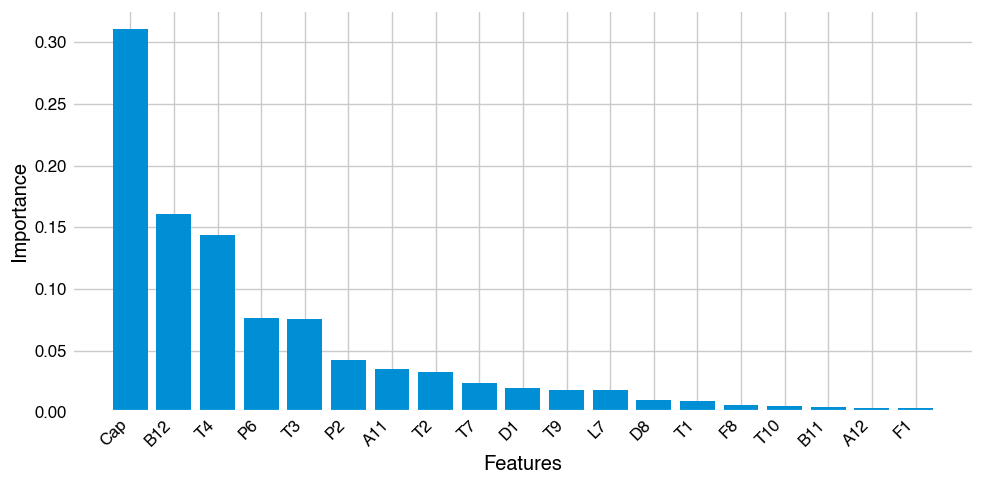

In [10]:
case = LinearModel()
case.preprocess(state='whole')

#df_train_sfs, df_test_sfs = case.fit_linear_regression_sfs(num_feat=13)
#df_train_en, df_test_en = case.fit_elastic_net_regression()
df_train_rf, df_test_rf = case.fit_random_forest_regression()

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File EN_parity_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lm/linear_models_case_1/EN_parity_plot.pdf.


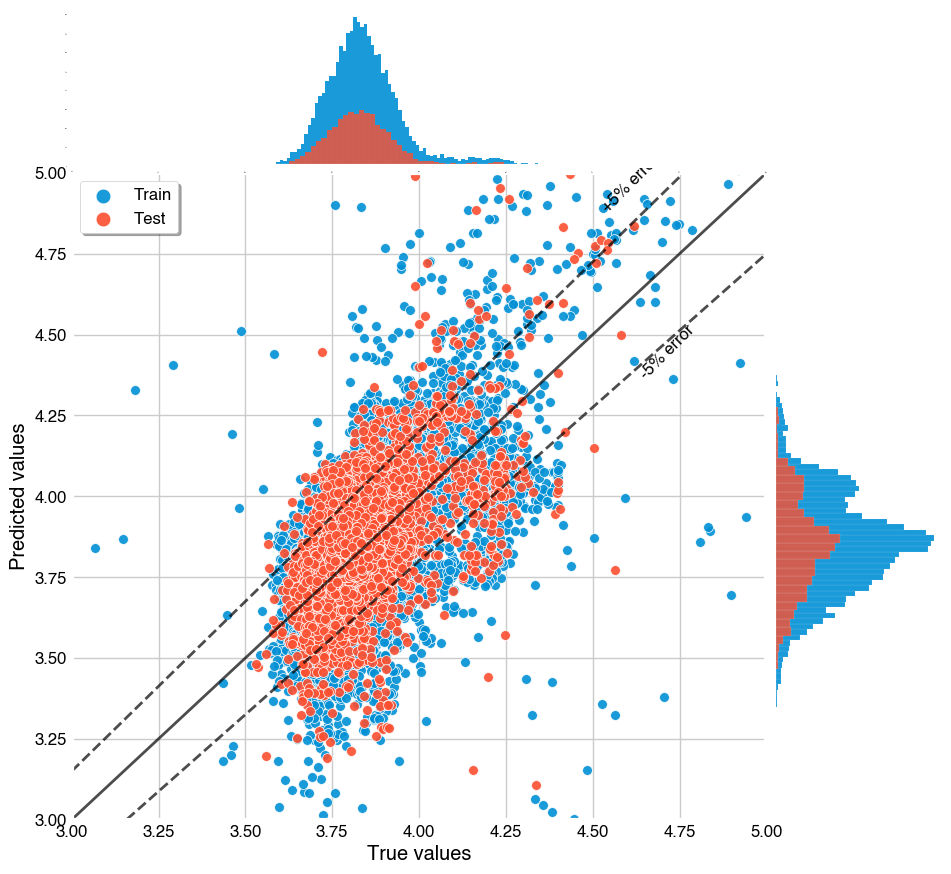

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


File EN_residuals_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lm/linear_models_case_1/EN_residuals_plot.pdf.


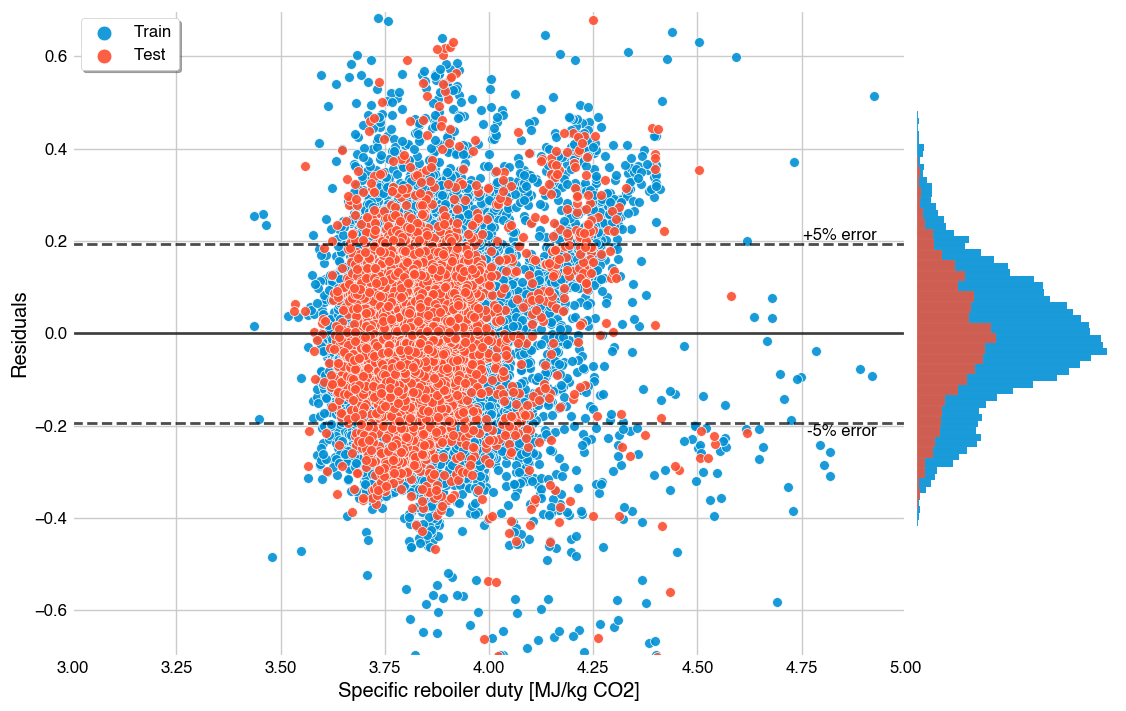

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

File EN_KDE_plot.pdf was saved to /Users/junxingli/Desktop/master_thesis/figs/lm/linear_models_case_1/EN_KDE_plot.pdf.


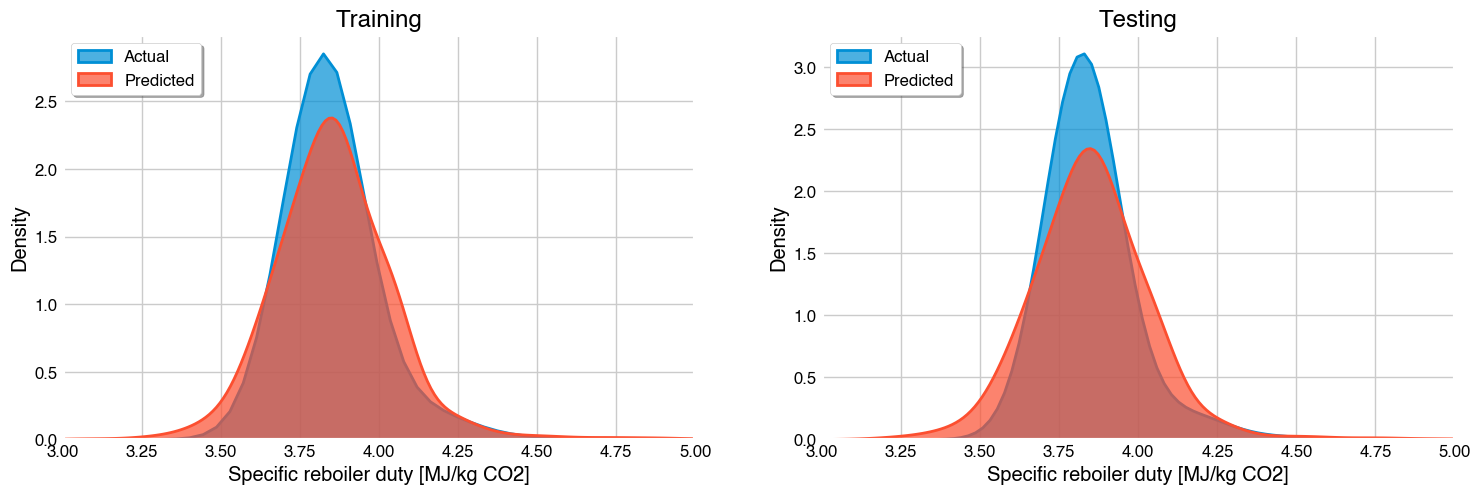

In [12]:
utils.make_evaluation_plots(df_train_en,
                            df_test_en,
                            'EN',
                            FIGS_DIR,
                            overwrite=False,
                            limit=[3.0, 5],
                            error_line=0.05,
                            res_limit=[-0.7, 0.7],
                            mean=pd.read_pickle("../data/processed/SRD_Lysekil.pkl")['SRD'].mean())

## Logs

### Steady state dataset

### Full dataset